# NYU Web Publishing: Site Setup Wizard

A current project for the NYU Web Publishing platform is the design and development of a new site creation workflow.  My goal with this project is to create a workflow that results in fewer abandoned sites. We currently have a large number of abandoned sites within our network and we're unable to retire them due to resource constraints.

However, before design can even start, I needed to understand how the current site creation process is being used.  The current process is implemented as [a plugin by Neel Shah](https://github.com/neelakansha85/site-setup-wizard).  For reference, the process has 4 steps:
1. User selects one of these use cases for their site: Teaching & Learning, Portfolio, Administrative, or Research. This doesn't change any part of the process, it simply provides us with that data.
2. Users fill out a form to specify URL, site title, and privacy settings.
3. Theme selection.
4. Select plugins. This step is said to be optional in UX text.
5. Process completed. Users receive a link to their new site.

There is one way around this module for creating copies of other sites, so while the majority of sites are created through the above process, not all are.

Based on my understanding of this process, I wanted to know the following:
* How many sites creation processes were abandoned?
* Where do users abandon the process?
* what kinds of users (students, faculty, or administrators) create sites?
* What kinds of users abandon?
* How long do users spend on creating their sites?
* How many sites do users usually create?

Many of these questions were focused on defining the user groups that I wanted to focus on when collecting qualitiative data.  The primary customer in university academic technology is usually thought to be faculty, but I'm always suspicious considering the size of the student population.

Now, for the data:

In [1]:
# Standard imports for wrangling and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# date and time handling
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

When I initially ran this analysis, I was pulling data from 3 different sources:
1. The core dataframe was from the Site Setup Wizard (SSW) table in the product database. This records transactions through the creation process.
2. User data from the wp_users table in WordPress multisite, the underlying technology of our product. This was important as it contained the unique user_id assigned to each user.
3. User role information. Using the login information from wp_users, I was able to pull semi-complete data about each user from the university Student Information System (SIS).

I cleaned and merged the above data sources, a process I've left out here due to the amount of PII involved.  For our purposes I've created an anonymized version of the output of that process with dummy logins and site titles.  

In [2]:
df = pd.read_csv('anon_data.csv')

In [3]:
df.head()

,ssw_id,user_id,u_role,u_division,title,privacy,template,theme,plugins_list,next_stage,site_type,blog_id,ssw_main_meta,site_created,wizard_completed,starttime,endtime,anon_login
0,3631,4638,Student,College of Arts and Science (undergraduate),Manager clear world always price friend.,1.0,NaN,NaN,a:3:{i:0;s:31:\bu-navigation/bu-navigation.php...,ssw_finish,Personal,3015.0,NaN,1,1,2015-11-09 14:30:15,2015-11-09 14:39:07,darlene04
1,3632,8051,Other,School of Law,Hot pick light glass street home dinner.,-2.0,NaN,NaN,a:0:{},ssw_finish,Teaching/Learning/Research,3016.0,NaN,1,1,2015-11-09 21:26:23,2015-11-09 21:30:01,warren20
2,3634,4562,Staff,NYU IT,Enjoy reduce provide lead spring attention pol...,NaN,NaN,NaN,NaN,ssw_step2,Personal,NaN,NaN,0,0,2015-11-10 11:07:50,2015-11-10 11:07:50,xwood
3,3635,8051,Other,School of Law,Maintain himself population rate by.,-2.0,NaN,NaN,a:0:{},ssw_finish,Teaching/Learning/Research,3017.0,NaN,1,1,2015-11-10 11:24:52,2015-11-10 11:25:44,warren20
4,3636,7729,Staff,NYU IT,Race friend beyond activity. Writer several ma...,-2.0,NaN,NaN,a:0:{},ssw_finish,Administrative,3018.0,NaN,1,1,2015-11-10 11:44:30,2015-11-10 11:48:44,kevin06


To start the analysis, I wanted to know what our completion rate was.

Text(0.5,0,'Process Completed (Boolean)')

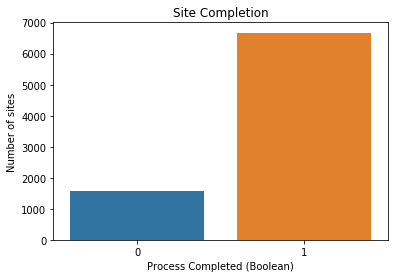

In [4]:
completion = df['wizard_completed'].value_counts()

sns.barplot(completion.index, completion.values)
plt.title('Site Completion')
plt.ylabel('Number of sites')
plt.xlabel('Process Completed (Boolean)')
# plt.savefig('raw_completion.png', dpi=200)

In [5]:
completion

1    6675
0    1577
Name: wizard_completed, dtype: int64

We can see that of 8252 attempts, 1577 abandoned. (19%)

Next question is "where did they leave the process?"

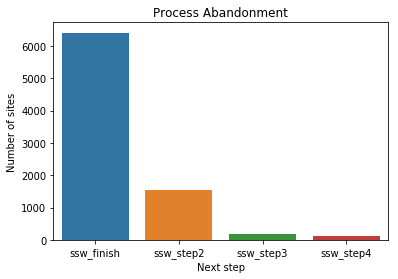

In [49]:
# check the next stage for all sites
left_process = df['next_stage'].value_counts().sort_index()

sns.barplot(left_process.index, left_process.values)
plt.title('Process Abandonment')
plt.ylabel('Number of sites')
plt.xlabel('Next step')
# plt.savefig('raw_abandonment.png', dpi=200)

ssw_step2 is higher than expected.  It seems to make sense that most would leave at the final step "ssw_finish".

Now, I'll check for sites where the process was not completed, according to the data.  (It should be noted that at some point the accuracy of this could come into question as we recently had to implement a bit of code to set their site creation process as completed to fix a bug.  For my initial research, I'm not concerned.)

Text(0.5,0,'Next step')

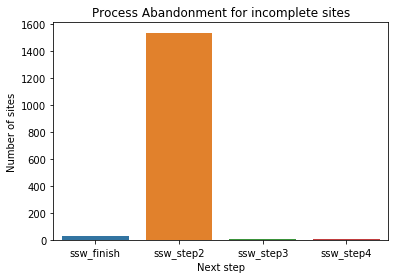

In [6]:
# check next stage for sites that were not completed
# shows that all process abandonment happened on the first page
# ssw_finish, but wizard_complete = 0 seems like a bug
l_process_incomplete = df['next_stage'].loc[df['wizard_completed'] == 0].value_counts().sort_index()

sns.barplot(l_process_incomplete.index, l_process_incomplete.values)
plt.title('Process Abandonment for incomplete sites')
plt.ylabel('Number of sites')
plt.xlabel('Next step')
# plt.savefig('incomplete_abandonment.png', dpi=200)

We can see that most users who abandon, abandon on the first step.

Next, what types of users are creating sites?

Text(0.5,0,'Role')

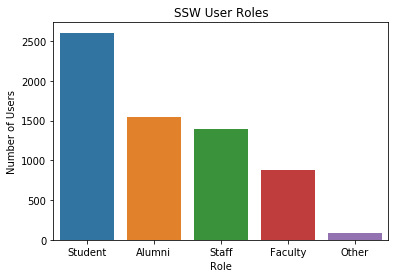

In [7]:
roles = df['u_role'].value_counts()

sns.barplot(roles.index, roles.values)
plt.title('SSW User Roles')
plt.ylabel('Number of Users')
plt.xlabel('Role')
# plt.savefig('user_role', dpi=200)

Our system is closed to alumni, so these alumni were students when they created their sites. (Or, the vast majority were.  If you complete a degree at NYU, work as staff for 20 years, and then leave the university, your role will also revert to alumni.)

With that in mind, I will change alumni to students and recreate the visualization.

In [12]:
df['u_role'].replace('Alumni', 'Student', inplace=True)

Text(0.5,0,'Role')

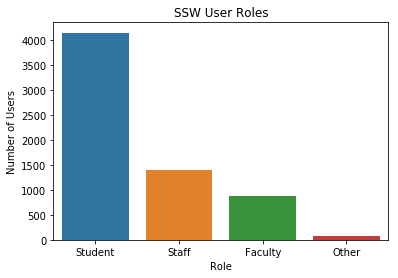

In [14]:
roles = df['u_role'].value_counts()

sns.barplot(roles.index, roles.values)
plt.title('SSW User Roles')
plt.ylabel('Number of Users')
plt.xlabel('Role')

The data so far has suggested that students are most commonly using this process for site creation.

Next, I'd like to see if any groups are particularly prone to not completing creation.

In [15]:
role = df[['u_role', 'wizard_completed','ssw_id']].groupby(['wizard_completed','u_role']).count()

In [16]:
role

ssw_id
wizard_completed u_role         
0                Faculty     139
                 Other        16
                 Staff       257
                 Student     915
1                Faculty     735
                 Other        65
                 Staff      1133
                 Student    3227

In [17]:
com_role = pd.pivot_table(df[['u_role', 'wizard_completed', 'ssw_id']], index='u_role', columns='wizard_completed', aggfunc=pd.Series.nunique)

com_role

ssw_id      
wizard_completed      0     1
u_role                       
Faculty             139   735
Other                16    65
Staff               235  1044
Student             915  3227

Next up, I want a rough idea of how many sites are creating.  The clients we most often interact with create many sites, so I'm curious if that is true across more of our customers. However, the data shows that the vast majority of users only create a single site, and about 700-800 have created 2. (I'm excluding this specific user_id here as it regularly creates and deletes sites as part of automated testing.)

Text(0.5,0,'Number of sites')

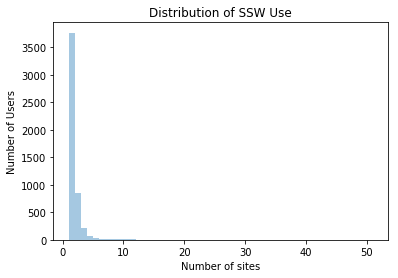

In [23]:
netid_count = df['anon_login'].loc[df['user_id'] != 20636].value_counts()

sns.distplot(netid_count, kde=False)
plt.title('Distribution of SSW Use')
plt.ylabel('Number of Users')
plt.xlabel('Number of sites')
# plt.savefig('ssw_dist', dpi=200)

Next question: How long does it take people to complete or not complete the process?

This required lots of time working with timestamp conversions.

In [24]:
df['dur'] = pd.to_datetime(df['endtime']).astype('datetime64[s]') - pd.to_datetime(df['starttime']).astype('datetime64[s]')

In [26]:
# not sure if this is needed
dur_delta = df['dur']

In [27]:
# duration in seconds
df['dur'].value_counts()

0 days 00:00:00      1535
0 days 00:00:16       104
0 days 00:00:12        97
0 days 00:00:15        90
0 days 00:00:11        87
0 days 00:00:14        70
0 days 00:00:17        42
0 days 00:00:26        40
0 days 00:02:12        27
0 days 00:01:52        26
0 days 00:00:18        23
0 days 00:01:45        23
0 days 00:01:36        23
0 days 00:00:55        23
0 days 00:01:58        22
0 days 00:02:47        21
0 days 00:02:55        21
0 days 00:02:59        21
0 days 00:02:11        21
0 days 00:01:30        21
0 days 00:02:29        21
0 days 00:03:01        20
0 days 00:01:51        20
0 days 00:03:00        20
0 days 00:00:20        20
0 days 00:02:17        20
0 days 00:02:38        20
0 days 00:02:06        20
0 days 00:02:30        20
0 days 00:01:48        20
                     ... 
2 days 23:48:18         1
67 days 22:40:46        1
63 days 06:19:14        1
16 days 01:50:07        1
0 days 09:39:55         1
126 days 03:15:05       1
8 days 08:17:27         1
0 days 19:29

There are some crazy outliers, so I'm limiting my research to those who took between 1 second and 1 hour to create a site.

In [28]:
delta_h = df['dur'].loc[(df['dur'] < pd.Timedelta(3600, 's')) &\
                       (df['dur'] > pd.Timedelta(1, 's'))]

In [29]:
delta_h.describe()

count                      5837
mean     0 days 00:05:15.880931
std      0 days 00:07:01.163403
min             0 days 00:00:11
25%             0 days 00:01:43
50%             0 days 00:03:21
75%             0 days 00:06:07
max             0 days 00:58:22
Name: dur, dtype: object

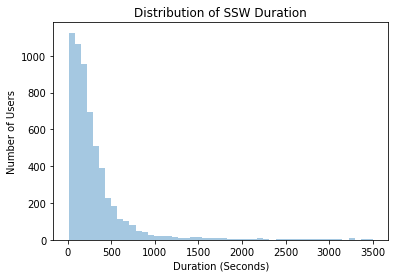

In [30]:
sns.distplot(delta_h.astype('timedelta64[s]'), kde=False)
plt.title('Distribution of SSW Duration')
plt.ylabel('Number of Users')
plt.xlabel('Duration (Seconds)')
# plt.savefig('ssw_timedelta_dist', dpi=200)

The distribution was a relief to see, as our users are currently not spending an inordinate amount of time on the process, for the most part.

## Conclusion

Overall, this data led to a couple of outcomes:
1. The qualitative user research is starting with a focus on students.  They are the largest population of users within the product, and they are also our main source of new sites through the SSW. Keeping them happy and ensuring they can easily create sites is important for keeping the product healthy.
2. The majority of users only create a single site in the system.  This suggests that we should first focus on the single site creation process, before looking at features for more advanced users, such as bulk site creation.
3. Overall, there are no specific roles that have trouble with a particular step of the process.

There are always more insights that could be pulled from this data, but for now this was enough to set the direction of our qualitative research.